In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import *
from math import *

from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as cv

from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

matplotlib.rcParams.update({
#    'figure.autolayout': True,
#    'font.size': 10.0,
     'axes.grid': True,
     'axes.axisbelow': True,
#     'axes.edgecolor': 'black',
#    'axes.facecolor': '#E5E5EF',
#    'axes.facecolor': '#E0E0EF',
#    'axes.labelcolor': 'black',
#    'axes.titlesize': 15,
#    'axes.labelsize': 'large',    
#    'figure.figsize': (12, 7),
#    'figure.titlesize': 'x-large',
#    'grid.linewidth': 1,
#    'xtick.labelsize': 'large',
#    'ytick.labelsize': 'large',
     'xtick.color': 'black',
     'ytick.color': 'black',
#    'legend.fontsize': 'large',
})

In [2]:
steam = pd.read_csv("./steam.csv")
df = steam
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
df.loc[:,'owners'] = df.loc[:,'owners'].str.split('-', expand=True).iloc[:,1]
df['owners'] = df['owners'].astype(int)

#df = df[(df.positive_ratings > 0) & (df.negative_ratings > 0)]
#df = df[(df.positive_ratings > 100) | (df.negative_ratings > 100)]
#df['owners'].value_counts().sort_values(axis=0)
#df = df[(df.owners > 20000)]
#df = df[df.price <= 60]

df['total_ratings'] = df['positive_ratings'] + (df['negative_ratings'])
df['score'] = df['positive_ratings'] / df['total_ratings']
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
#df['release_month'] = pd.DatetimeIndex(df['release_date']).month
df.isnull().any().sum()

0

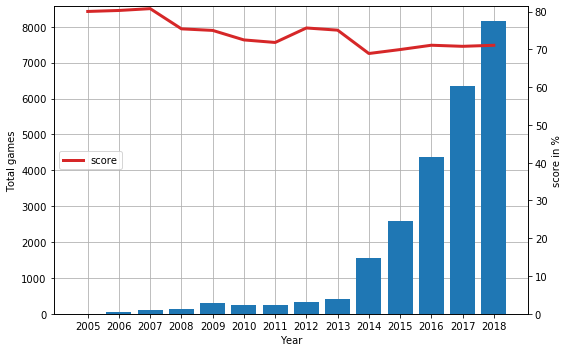

In [4]:
matplotlib.rcParams.update({'figure.figsize': (8, 5)})
fig, ax1 = plt.subplots()
yearly = df.groupby(df.release_year).agg('count').appid
ratings = df.groupby(df.release_year)['score'].mean()
min_year = 2005
max_year = 2018
yearly = yearly[(yearly.index >= min_year) & (yearly.index <= max_year)]
ratings = ratings[(ratings.index >= min_year) & (ratings.index <= max_year)]
#plt.title(f'Number of games released in {min_year}-{max_year} years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total games')
ax1.set_xticks(yearly.index)
#plt.yticks(yearly_part)
ax1.bar(yearly.index, yearly,label='releases')
ax2 = ax1.twinx()
ax2.set_zorder(1)
ax2.patch.set_visible(False)
ax2.set_ylabel('score in %')
ax2.plot(ratings.index, ratings, color='tab:red',linewidth=3,label='score')
ax2.set_yticks(np.arange(0, 0.9, 0.1))
ax2.set_yticklabels(np.arange(0, 90, 10))
fig.tight_layout()
ax2.grid(False)
ax2.grid(False)
plt.legend(loc="center left")
plt.savefig('images/number-games-year.pdf', bbox_inches='tight')
matplotlib.rcParams.update({'figure.figsize': (6.4, 4.8)})

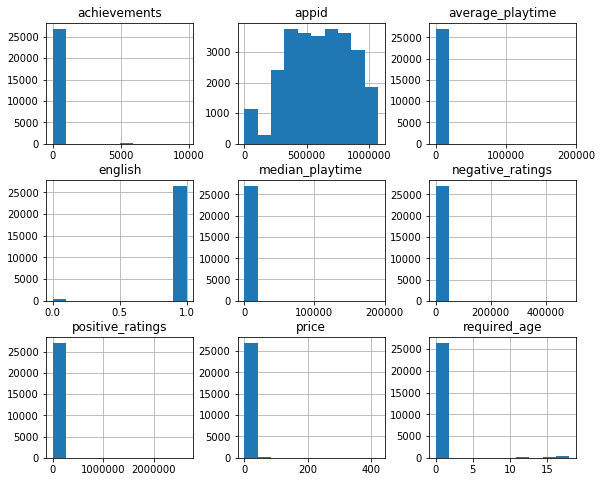

In [5]:
#df.loc[:, df.columns != 'release_year'].hist(figsize=(9.5,8), bins=10)
#df.hist(figsize=(9.5,8), bins=10)
cols = ['appid', 'achievements', 'english', 'average_playtime', 'median_playtime', 'price',
       'positive_ratings', 'negative_ratings', 'required_age']
df[cols].hist(figsize=(9.5,8), bins=10)
plt.savefig('images/hist.pdf', bbox_inches='tight')

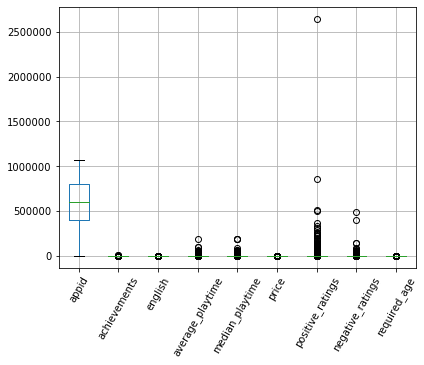

In [6]:
df[cols].boxplot(rot=60)
plt.savefig('images/boxplot.pdf', bbox_inches='tight')
#df.loc[:, df.columns != 'positive_ratings'].boxplot(rot=60)

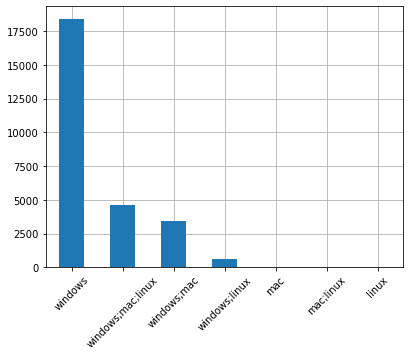

In [7]:
#plt.figure(figsize=(10,10))
df['platforms'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.savefig('images/platforms-7.pdf', bbox_inches='tight')

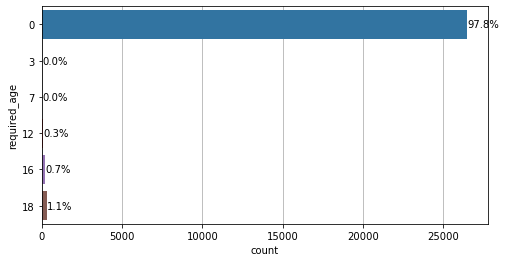

In [8]:
plt.figure(figsize=(8,4))
#df.groupby('required_age').size().plot(kind='bar')
#plt.title('required_age_count')
plt.xlabel('Number of count')
ax = sns.countplot(y=df['required_age'])
total = len(df['required_age'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    #ax.annotate(percentage, (x, y))
    ax.text(x, y, percentage, ha="left",va="center")
        
plt.savefig('images/required-age.pdf', bbox_inches='tight')

#for p in ax.patches:
#    percentage = '{:.2f}%'.format(100 * p.get_height()/total)
#    x = p.get_x() + p.get_width()/2
#    y = p.get_y() + p.get_height()
#    ax.annotate(percentage, (x, y), ha="center",va="bottom")  

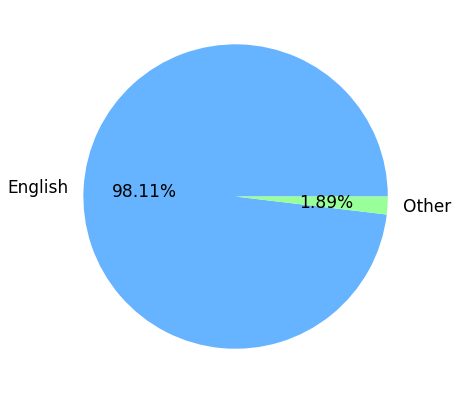

In [9]:
plt.figure(figsize=(7,7))
colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999']
#df['english'].value_counts().plot(kind='pie', autopct='%.2f')
plt.pie(df['english'].value_counts(), labels=['English', 'Other'],
        colors=colors, autopct='%1.2f%%', textprops=dict(color="black", size=17))
plt.savefig('images/english.pdf', bbox_inches='tight')

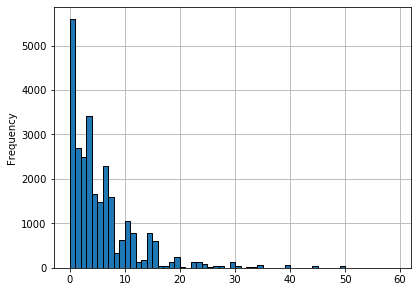

In [10]:
df['price'].plot(kind='hist', bins=range(0,60), ec='black', rwidth = 1, range=None)
plt.savefig('images/price.pdf', bbox_inches='tight')

1000.5585226223453
24
27075


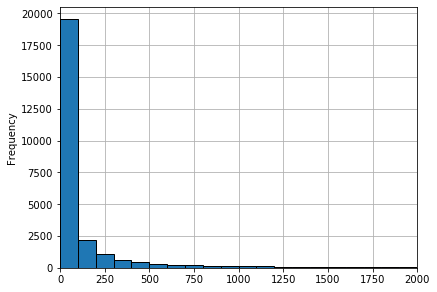

In [11]:
print(mean(df['positive_ratings']))
print(median(df['positive_ratings']))
#dff = df.loc[df['positive_ratings'] >= 0]
#dff2 = df[df['positive_ratings'] >= 0]
count = len(df['positive_ratings'])
print(count)
df['positive_ratings'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 2000))
plt.savefig('images/positive-ratings.pdf', bbox_inches='tight')

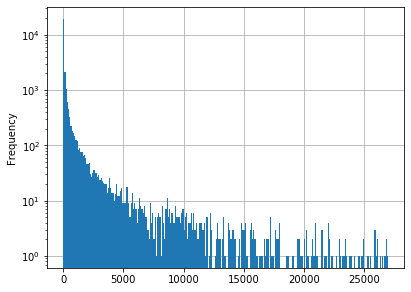

In [12]:
count = len(df['positive_ratings'])
df['positive_ratings'].plot(kind='hist', logy=True, bins=range(0,count, 100), rwidth = 1)
plt.savefig('images/positive-ratings-log.pdf', bbox_inches='tight')

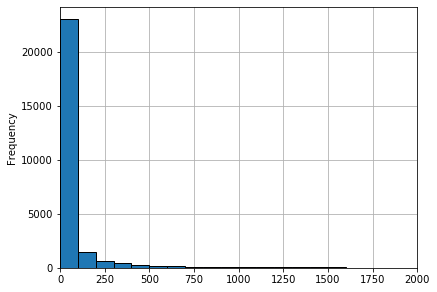

In [13]:
count = len(df['negative_ratings'])
df['negative_ratings'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 2000))
plt.savefig('images/negative-ratings.pdf', bbox_inches='tight')

In [14]:
#df['diff_ratings'] = df['positive_ratings'] - df['negative_ratings']
#count = len(df['diff_ratings'])
#minim = min(df['diff_ratings'])
#maxim = max(df['diff_ratings'])
#df['diff_ratings'].plot(kind='hist', bins=range(-5000,10000, 1000), ec='black', rwidth = 1)
#plt.savefig('images/diff-ratings.pdf', bbox_inches='tight')

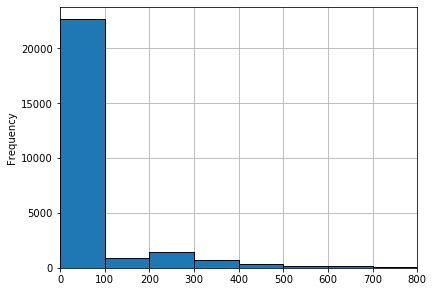

In [15]:
count = len(df['median_playtime'])
df['median_playtime'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 800))
plt.savefig('images/median-playtime.pdf', bbox_inches='tight')

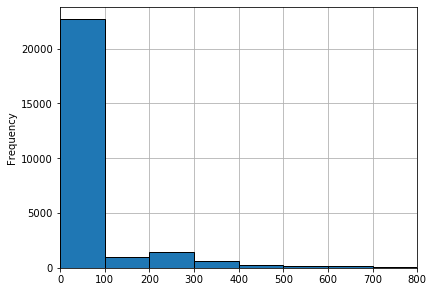

In [16]:
count = len(df['average_playtime'])
df['average_playtime'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 800))
plt.savefig('images/average-playtime.pdf', bbox_inches='tight')

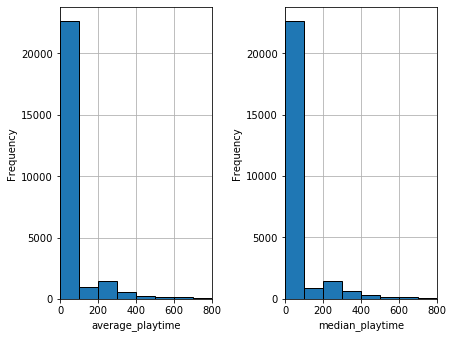

In [17]:
count = len(df['average_playtime'])

plt.subplot(1, 2, 1)
plt.xlabel("average_playtime")
df['average_playtime'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 800))
plt.subplot(1, 2, 2)
plt.xlabel("median_playtime")
df['median_playtime'].plot(kind='hist', bins=range(0,count, 100), ec='black', rwidth = 1, xlim=(0, 800))
plt.tight_layout()
plt.savefig('images/playtime.pdf', bbox_inches='tight')

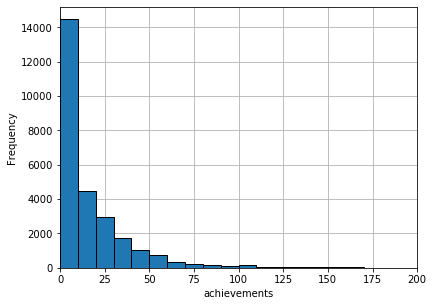

In [18]:
count = len(df['achievements'])
df['achievements'].plot(kind='hist', bins=range(0,count, 10), edgecolor='black', rwidth = 1, xlim=(0, 200))
plt.xlabel("achievements")
plt.savefig('images/achievements.pdf', bbox_inches='tight')

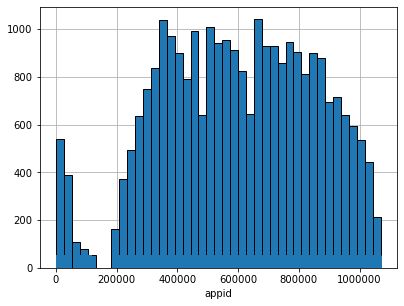

In [19]:
sns.distplot(df['appid'], kde=False, rug=True, hist_kws={"rwidth":1,'edgecolor':'black', 'alpha':1.0});
plt.savefig('images/appid.pdf', bbox_inches='tight')

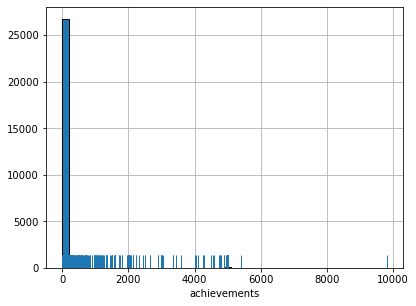

In [20]:
sns.distplot(df['achievements'], kde=False, rug=True, hist_kws={"rwidth":1,'edgecolor':'black', 'alpha':1.0});
plt.savefig('images/achievements-sns.pdf', bbox_inches='tight')

In [21]:
platforms = df['platforms'].str.get_dummies(';')
df = pd.concat([df.drop('platforms', axis=1), platforms], axis=1)
platforms

,linux,mac,windows
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,0,0,1
27071,0,0,1
27072,0,0,1
27073,0,1,1


In [22]:
genres = df['genres'].str.get_dummies(';')
genres.rename(columns={'Massively Multiplayer':'MMO', 'Free to Play':'F2P','Early Access':'Alpha'}, inplace=True)
genres

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Alpha,Education,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
genres.mean().sort_values(ascending=False)

Indie                    0.717304
Action                   0.439631
Casual                   0.377101
Adventure                0.370526
Strategy                 0.193795
Simulation               0.191837
RPG                      0.159224
Alpha                    0.109104
F2P                      0.062936
Sports                   0.048827
Racing                   0.037821
Violent                  0.031136
MMO                      0.026704
Gore                     0.019834
Nudity                   0.009825
Sexual Content           0.009049
Utilities                0.005392
Design & Illustration    0.003213
Animation & Modeling     0.002918
Education                0.001884
Video Production         0.001404
Software Training        0.001145
Audio Production         0.001071
Web Publishing           0.001034
Game Development         0.000628
Photo Editing            0.000443
Accounting               0.000222
Documentary              0.000037
Tutorial                 0.000037
dtype: float64

In [24]:
col_names = genres.mean()[genres.mean() > 0.01].sort_values(ascending=False).keys()

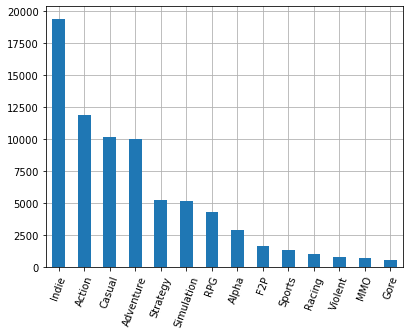

In [25]:
genres[col_names].sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=70)
plt.savefig('images/genres.pdf', bbox_inches='tight')

In [26]:
df = pd.concat([df.drop('genres', axis=1), genres[col_names]], axis=1)
df.loc[:, (df != 0).any(axis=0)]

,appid,name,release_date,english,developer,publisher,required_age,categories,steamspy_tags,achievements,...,Strategy,Simulation,RPG,Alpha,F2P,Sports,Racing,Violent,MMO,Gore
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,Multi-player;Valve Anti-Cheat enabled,FPS;World War II;Multiplayer,0,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,Single-player;Multi-player;Valve Anti-Cheat en...,FPS;Action;Sci-fi,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,0,Single-player;Steam Achievements,Adventure;Indie;Casual,7,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,0,Single-player,Action;Indie;Adventure,0,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Indie;Casual,24,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,0,Single-player;Steam Cloud,Indie;Casual;Adventure,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df = df[df[col_names].sum(axis=1) > 0]
df = df[df['english'] == 1]
df = df.drop(['categories', 'steamspy_tags', 'english'], axis=1)
len(df)

26408

In [28]:
df[['appid', 'required_age', 'achievements', 'price']].head()
df.select_dtypes(include='number')

,appid,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,...,Strategy,Simulation,RPG,Alpha,F2P,Sports,Racing,Violent,MMO,Gore
0,10,0,0,124534,3339,17612,317,20000000,7.19,127873,...,0,0,0,0,0,0,0,0,0,0
1,20,0,0,3318,633,277,62,10000000,3.99,3951,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,3416,398,187,34,10000000,3.99,3814,...,0,0,0,0,0,0,0,0,0,0
3,40,0,0,1273,267,258,184,10000000,3.99,1540,...,0,0,0,0,0,0,0,0,0,0
4,50,0,0,5250,288,624,415,10000000,3.99,5538,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,0,7,3,0,0,0,20000,2.09,3,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,0,0,8,1,0,0,20000,1.69,9,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,0,24,0,1,0,0,20000,3.99,1,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,0,0,2,0,0,0,20000,5.19,2,...,0,0,0,0,0,0,0,0,0,0


In [29]:
##PCA PLOTS IT IN R WITH RCOMMANDER

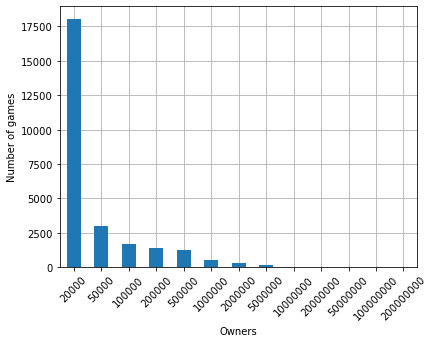

In [30]:
df['owners'].value_counts().sort_values(ascending=False).plot(kind='bar')
#plt.gca().invert_yaxis()
plt.xlabel('Owners')
plt.ylabel('Number of games')
plt.xticks(rotation=45)
plt.savefig('images/owners.pdf', bbox_inches='tight')

In [31]:
df['owners'].value_counts()

20000        18061
50000         2995
100000        1666
200000        1364
500000        1263
1000000        510
2000000        285
5000000        192
10000000        45
20000000        21
50000000         3
100000000        2
200000000        1
Name: owners, dtype: int64

In [32]:
df.describe(percentiles=[], include='all')

,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,...,Strategy,Simulation,RPG,Alpha,F2P,Sports,Racing,Violent,MMO,Gore
count,2.640800e+04,26408,26408,26408,26408,26408.000000,26408.000000,2.640800e+04,26408.000000,26408.000000,...,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000,26408.000000
unique,NaN,26367,2616,16665,13958,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Dark Matter,2018-07-13 00:00:00,Choice of Games,Big Fish Games,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3,64,94,212,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.923651e+05,NaN,NaN,NaN,NaN,0.357960,46.192820,1.018124e+03,215.227431,150.052446,...,0.193237,0.192517,0.154650,0.109285,0.062292,0.049871,0.038663,0.031506,0.026431,0.020070
std,2.503550e+05,NaN,NaN,NaN,NaN,2.415091,357.029093,1.922196e+04,4338.533188,1828.989533,...,0.394845,0.394285,0.361578,0.312002,0.241689,0.217683,0.192793,0.174683,0.160417,0.140241
min,1.000000e+01,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.940100e+05,NaN,NaN,NaN,NaN,0.000000,8.000000,2.500000e+01,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.069460e+06,NaN,NaN,NaN,NaN,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
first,NaN,NaN,1997-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


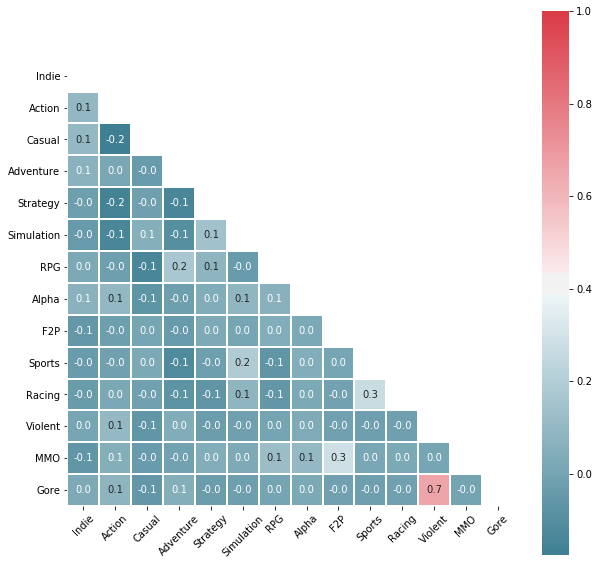

In [33]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal', adjustable='box')
corr = df.select_dtypes(include='number').corr()
col_genres = ['Indie', 'Action', 'Casual', 'Adventure',
       'Strategy', 'Simulation', 'RPG', 'Alpha', 'F2P',
       'Sports', 'Racing', 'Violent', 'MMO', 'Gore']
corr = df[col_genres].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, 0)] = True

ax = sns.heatmap(corr, annot=True, mask=mask, linewidth=1, fmt= ".1f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.xticks(rotation=45)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

plt.savefig('images/genres-heatmap.pdf', bbox_inches='tight')

In [34]:
df.columns
print(df.select_dtypes(include='number').columns)
columns = ['appid', 'release_year', 'required_age', 'achievements', 'owners', 'positive_ratings',
 'negative_ratings', 'average_playtime', 'median_playtime', 'price']

Index(['appid', 'required_age', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'owners',
       'price', 'total_ratings', 'score', 'release_year', 'linux', 'mac',
       'windows', 'Indie', 'Action', 'Casual', 'Adventure', 'Strategy',
       'Simulation', 'RPG', 'Alpha', 'F2P', 'Sports', 'Racing', 'Violent',
       'MMO', 'Gore'],
      dtype='object')


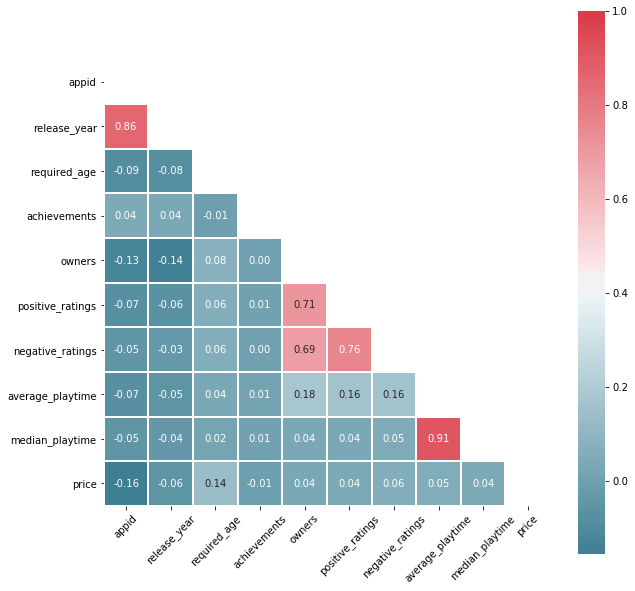

In [35]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal', adjustable='box')
corr = df.select_dtypes(include='number').corr()
corr = df[columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, 0)] = True
sns.heatmap(corr, annot=True, mask=mask, linewidth=1, fmt= ".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.xticks(rotation=45)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

plt.savefig('images/corr-heatmap.pdf', bbox_inches='tight')

In [36]:
columns = ['appid', 'required_age', 'positive_ratings', 'average_playtime', 'price']
#scatterPlots = pd.plotting.scatter_matrix(df[columns], figsize=(20,20))
#plt.savefig('images/scatter-plots.pdf', bbox_inches='tight')

In [37]:
#sns.pairplot(df[columns], plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'b'}, height = 4)
#plt.savefig('images/pair-plots.pdf', bbox_inches='tight')

In [38]:
#df.groupby('platforms').describe()
df.groupby(['windows', 'linux', 'mac']).describe()

appid                                                    \
                     count           mean            std       min       25%   
windows linux mac                                                              
0       0     1        3.0  492620.000000  248743.259808  214630.0  391840.0   
        1     0        1.0  805260.000000            NaN  805260.0  805260.0   
              1        1.0  594550.000000            NaN  594550.0  594550.0   
1       0     0    17811.0  616838.156925  252235.324272     630.0  439850.0   
              1     3391.0  575053.681510  249944.792673     500.0  374950.0   
        1     0      606.0  594436.039604  222867.669951    4920.0  404747.5   
              1     4595.0  510023.958215  227197.723589      10.0  338565.0   

                                                 required_age             ...  \
                        50%       75%        max        count       mean  ...   
windows linux mac                                                         ...   
0       0     1    569050.0  631615.0   694180.0          3.0   6.000000  ...   
        1     0    805260.0  805260.0   805260.0          1.0   0.000000  ...   
              1    594550.0  594550.0   594550.0          1.0  16.000000  ...   
1       0     0    636020.0  816220.0  1065650.0      17811.0   0.406996  ...   
              1    561260.0  783230.0  1069460.0       3391.0   0.219699  ...   
        1     0    574670.0  783125.0  1046430.0        606.0   0.351485  ...   
              1    461650.0  679250.0  1057710.0       4595.0   0.263765  ...   

                   MMO          Gore                                          \
                   75%  max    count      mean       std  min  25%  50%  75%   
windows linux mac                                                              
0       0     1    0.0  0.0      3.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
        1     0    0.0  0.0      1.0  0.000000       NaN  0.0  0.0  0.0  0.0   
              1    0.0  0.0      1.0  0.000000       NaN  0.0  0.0  0.0  0.0   
1       0     0    0.0  1.0  17811.0  0.023076  0.150148  0.0  0.0  0.0  0.0   
              1    0.0  1.0   3391.0  0.012681  0.111909  0.0  0.0  0.0  0.0   
        1     0    0.0  1.0    606.0  0.009901  0.099092  0.0  0.0  0.0  0.0   
              1    0.0  1.0   4595.0  0.015234  0.122495  0.0  0.0  0.0  0.0   

                        
                   max  
windows linux mac       
0       0     1    0.0  
        1     0    0.0  
              1    0.0  
1       0     0    1.0  
              1    1.0  
        1     0    1.0  
              1    1.0  

[7 rows x 208 columns]

In [39]:
platforms = df[['linux', 'mac', 'windows']].sum()
#platforms.plot(kind='barh')

In [40]:
#plt.figure(figsize=(7,7))
#df[['windows', 'linux', 'mac']].sum().plot(kind='pie', autopct='%1.1f%%', textprops=dict(color="w"))
#platforms = df[['windows', 'linux', 'mac']].sum()
#colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999']
#plt.pie(platforms, labels=platforms.index, colors=colors, autopct='%1.1f%%', textprops=dict(color="black", size=20))
#plt.savefig('images/platforms-pie.pdf', bbox_inches='tight')

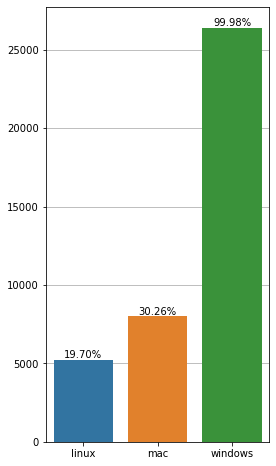

In [41]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(x=platforms.index, y=platforms.values)
total = platforms.sum()
total = len(df[['linux', 'mac', 'windows']])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(100*height/total),
            ha="center",va="bottom")
plt.savefig('images/platforms-bar.pdf', bbox_inches='tight')

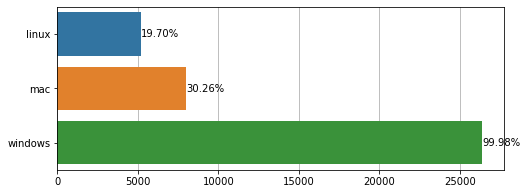

In [42]:
plt.figure(figsize=(8, 3))
ax = sns.barplot(y=platforms.index, x=platforms.values)
total = platforms.sum()
total = len(df[['linux', 'mac', 'windows']])
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    #ax.annotate(percentage, (x, y))
    ax.text(x, y, percentage, ha="left",va="center") 
plt.savefig('images/platforms-barh.pdf', bbox_inches='tight')

In [43]:
print(platforms)
len(df[['linux', 'mac', 'windows']])

linux       5203
mac         7990
windows    26403
dtype: int64


26408

In [44]:
## filtering ownership df[(df.owners > 20000)] does not change the clustering
dft = df[col_genres].transpose()
dists = pdist(dft, 'cosine')
dists_m = squareform(dists) ** 3
Z = linkage(squareform(dists_m), 'ward')

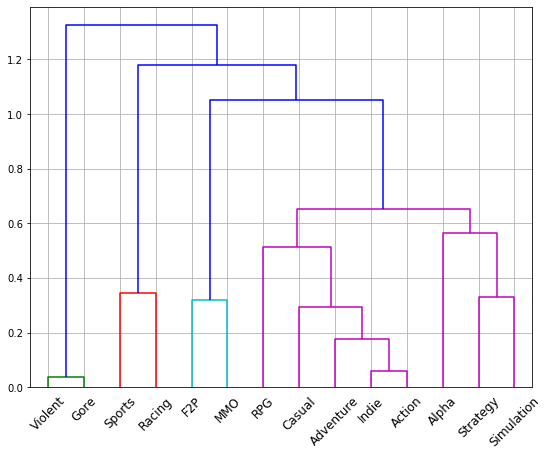

In [45]:
plt.figure(figsize=(9, 7))
dendrogram(
    Z,
    leaf_rotation=45,  # rotates the x axis labels
#   leaf_font_size='large',  # font size for the x axis labels
    orientation='top',
    labels=dft.index
)
plt.savefig('images/dendrogram-genres.pdf', bbox_inches="tight")

In [46]:
df.to_csv('steam-clean.csv', index = False)

In [47]:
#df['price'].describe()

In [48]:
#np.set_printoptions(suppress=True)
#sklearn.feature_selection.f_regression(X_train.select_dtypes(include='number'), y_train)[1]
#idx = np.argwhere(aa >= 0.05)
#X_train.select_dtypes(include='number').columns[idx]

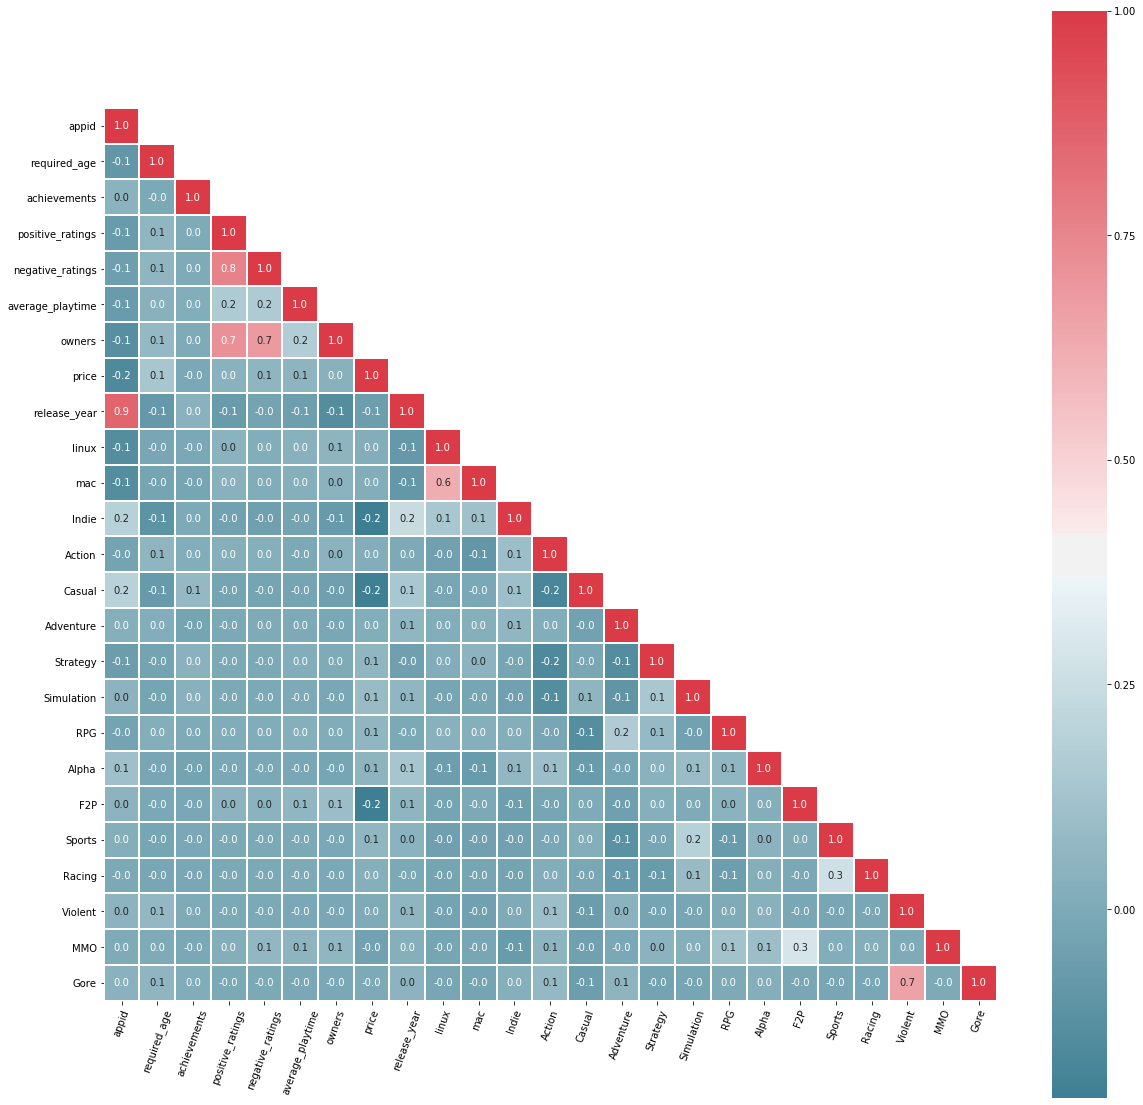

In [49]:
plt.figure(figsize=(20,20))
plt.gca().set_aspect('equal', adjustable='box')
corr = df.select_dtypes(include='number').corr()
cols = ['appid', 'required_age', 'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'owners', 'price', 'release_year', 'linux',
       'mac', 'Indie', 'Action', 'Casual', 'Adventure', 'Strategy',
       'Simulation', 'RPG', 'Alpha', 'F2P', 'Sports', 'Racing', 'Violent',
       'MMO', 'Gore']
corr = df[cols].corr()
#Removed windows, median_time, score, diff_ratings
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, 1)] = True

ax = sns.heatmap(corr, annot=True, mask=mask, linewidth=1, fmt= ".1f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.xticks(rotation=70)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

plt.savefig('images/heatmap.pdf', bbox_inches='tight')

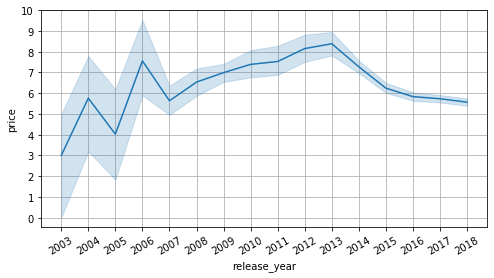

In [50]:
##PLOT PRICE BY YEAR
plt.figure(figsize=(8,4))
release_year = df['release_year'][(df.release_year >= 2003) & (df.release_year <= 2018)]
ax = sns.lineplot(release_year, df['price'])
ax.set_xticks(release_year.unique())
ax.set_yticks(range(11))
plt.xticks(rotation=30)
plt.savefig('images/price_year.pdf', bbox_inches='tight')

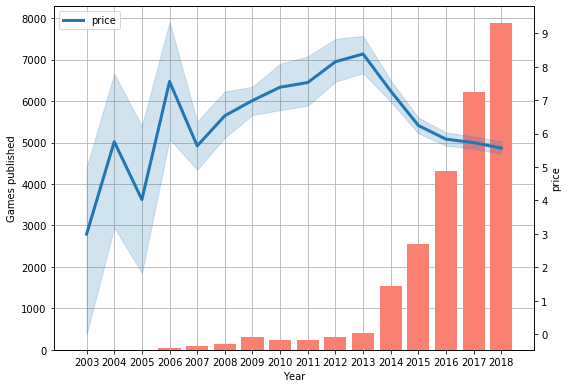

In [51]:
matplotlib.rcParams.update({'figure.figsize': (8, 5.5)})
fig, ax1 = plt.subplots()
yearly = df.groupby(df.release_year).agg('count').appid
#prices = df.groupby(df.release_year)['price'].mean()
min_year = 2003
max_year = 2018
yearly = yearly[(yearly.index >= min_year) & (yearly.index <= max_year)]
#prices = prices[(prices.index >= min_year) & (prices.index <= max_year)]
ax1.set_xlabel('Year')
ax1.set_ylabel('Games published')
ax1.set_xticks(yearly.index)
#plt.yticks(yearly_part)
ax1.bar(yearly.index, yearly,label='releases', color='salmon')
ax2 = ax1.twinx()
ax2.set_zorder(1)
ax2.patch.set_visible(False)
ax2.set_ylabel('price')
sns.lineplot(release_year, df['price'], ax=ax2, label='price',linewidth=3)
ax2.set_yticks(np.arange(0, 10, 1))
#ax2.set_yticklabels(np.arange(0, 90, 10))
fig.tight_layout()
ax2.grid(False)
ax2.grid(False)
plt.legend(loc="upper left")
plt.savefig('images/games-year-price.pdf', bbox_inches='tight')
matplotlib.rcParams.update({'figure.figsize': (6.4, 4.8)})

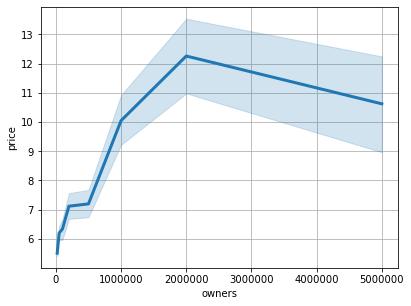

In [52]:
sns.lineplot(x=df['owners'][df.owners <= 5000000], y=df['price'],linewidth=3)
plt.savefig('images/price-owners.pdf', bbox_inches='tight')

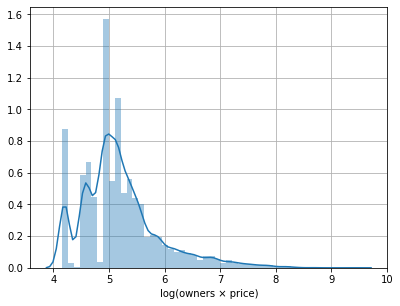

In [53]:
revenue = df['owners']*df['price']
revenue = np.log10(revenue[revenue != 0])
ax = sns.distplot(revenue)
ax.set_xlabel('log(owners × price)')
#ax.set_xticks(np.arange(8, 23, 1))
plt.savefig('images/dist-owners-price.pdf', bbox_inches='tight')